In [21]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from typing import List, Dict, Tuple

import importlib
import utils.preprocess
import utils.baseline
import utils.model
importlib.reload(utils.preprocess)
importlib.reload(utils.baseline)
importlib.reload(utils.model)

from utils.preprocess import DataWindow
from utils.baseline import Baseline, MultiStepBaseline, RepeatBaseline
from utils.model import LinearModel, ModelTrainer

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'notebook'

In [2]:
# データのダウンロード
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

In [4]:
# データの確認
train_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.00,0.758755,0.146447,0.853553
1,0.738174,0.00,0.560765,0.250000,0.933013
2,0.698884,0.00,0.463513,0.370590,0.982963
3,0.668238,0.00,0.370029,0.500000,1.000000
4,0.643093,0.00,0.325101,0.629410,0.982963
...,...,...,...,...,...
12280,0.422599,0.90,0.599972,0.250000,0.066987
12281,0.421656,0.75,0.561881,0.146447,0.146447
12282,0.436272,0.90,0.567881,0.066987,0.250000
12283,0.439415,0.75,0.644482,0.017037,0.370590


# 13. ディープラーニングのためのデータウィンドウとベースラインの作成

## 13.2 ベースラインモデルを実装する

### 13.2.1 シングルステップのベースラインモデル

In [3]:
# シングルステップモデル用のデータウィンドウの作成（次の時間ステップを予測するモデル）
single_step_window = DataWindow(
    input_width=1, 
    label_width=1, 
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

# プロット時に可視化できるモデルの予測値の数を増やすために、より広いウィンドウも定義
wide_window = DataWindow(
    input_width=24, 
    label_width=24, 
    shift=1, 
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

In [4]:
# 訓練データセットの各列の名前とインデックスが含まれたdictを生成
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Baselineクラスに目的変数列のインデックスを渡す
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

In [5]:
def evaluate_model(model: nn.Module, dataloader: DataLoader) -> tuple[float, float]:
    """
    モデルの評価を行う関数。

    Args:
        model (nn.Module): 評価するモデル
        dataloader (DataLoader): 評価用データローダー

    Returns:
        tuple[float, float]: MSEおよびMAEの評価結果
    """
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            predictions = model(inputs)
            
            # PyTorchの関数で直接テンソルを評価
            mse = torch.nn.functional.mse_loss(predictions, targets)
            mae = torch.nn.functional.l1_loss(predictions, targets)

            total_mse += mse.item()  # item()で数値に変換
            total_mae += mae.item()
            num_batches += 1

    # 平均値を返す
    return total_mse / num_batches, total_mae / num_batches


In [9]:
# 評価用とテスト用のdataloaderを作成
val_dataloader = single_step_window.val
test_dataloader = single_step_window.test

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(baseline_last, val_dataloader)
test_mse, test_mae = evaluate_model(baseline_last, test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.013302249812775037, 'MAE': 0.08302514993331649}}
Test Performance: {'Baseline - Last:': {'MSE': 0.012465668037872423, 'MAE': 0.08124568916179917}}


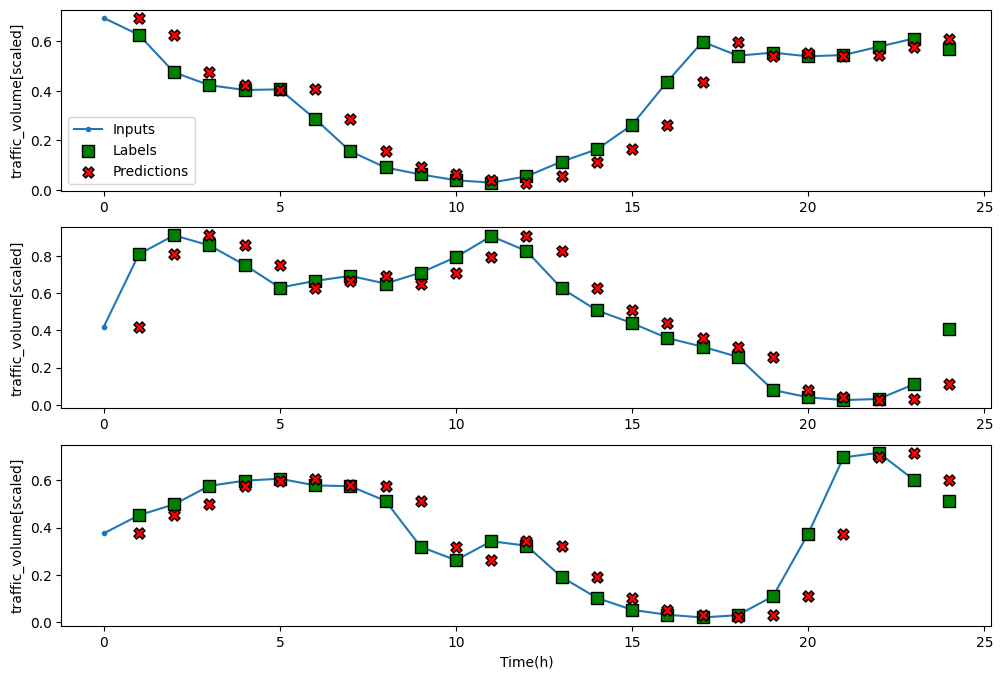

In [9]:
# 予測値の可視化(データ点を3つ以上表示する場合はwide_windowを使う)
wide_window.plot(baseline_last)

### 13.2.2 マルチステップのベースラインモデル

- 最後の既知の値を予測する

In [6]:
# マルチステップモデル用のデータウィンドウの作成（24時間分の入力から次の24時間の交通量を予測するモデル）
multi_window = DataWindow(
    input_width=24,
    label_width=24,
    shift=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['traffic_volume']
)

In [12]:
# MultiStepBaselineクラスに目的変数列のインデックスを渡す
ms_baseline_last = MultiStepBaseline(label_index=column_indices['traffic_volume'])

# 評価用とテスト用のdataloaderを作成
val_dataloader = multi_window.val
test_dataloader = multi_window.test

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(ms_baseline_last, val_dataloader)
test_mse, test_mae = evaluate_model(ms_baseline_last, test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.15009007192806367, 'MAE': 0.3093458397672811}}
Test Performance: {'Baseline - Last:': {'MSE': 0.14216725003940087, 'MAE': 0.3015991040953883}}


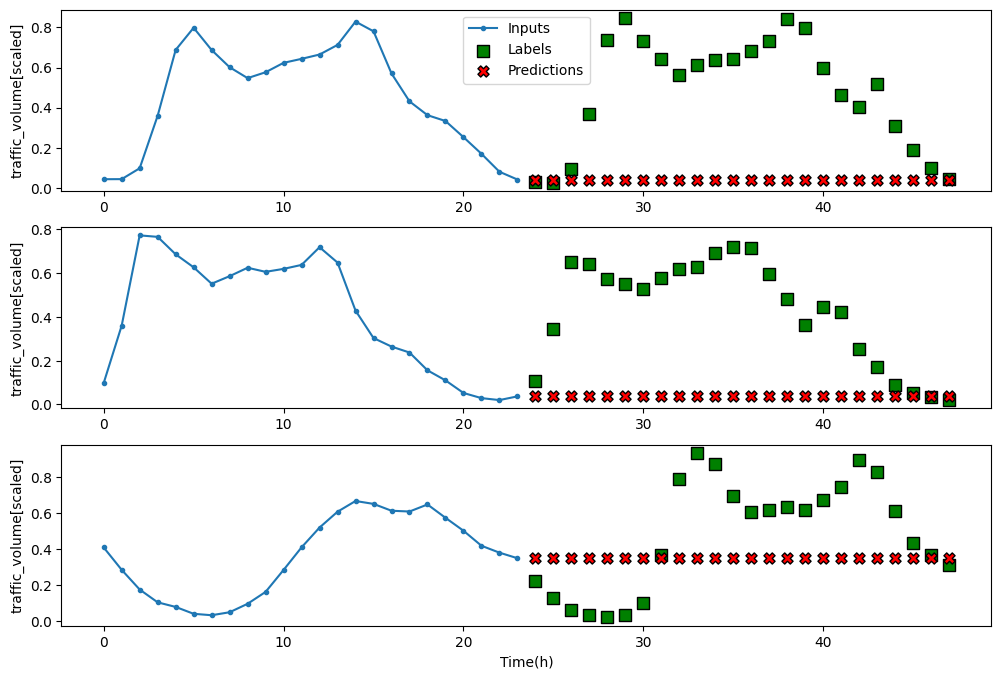

In [14]:
# 予測値の可視化
multi_window.plot(ms_baseline_last)

- 入力シーケンスを繰り返す

In [7]:
# RepeatBaselineクラスに目的変数列のインデックスを渡す
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

# 評価用とテスト用のdataloaderを作成
val_dataloader = multi_window.val
test_dataloader = multi_window.test

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(ms_baseline_repeat, val_dataloader)
test_mse, test_mae = evaluate_model(ms_baseline_repeat, test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.022475608906477963, 'MAE': 0.08135393292668762}}
Test Performance: {'Baseline - Last:': {'MSE': 0.01703685259067074, 'MAE': 0.06770451470381683}}


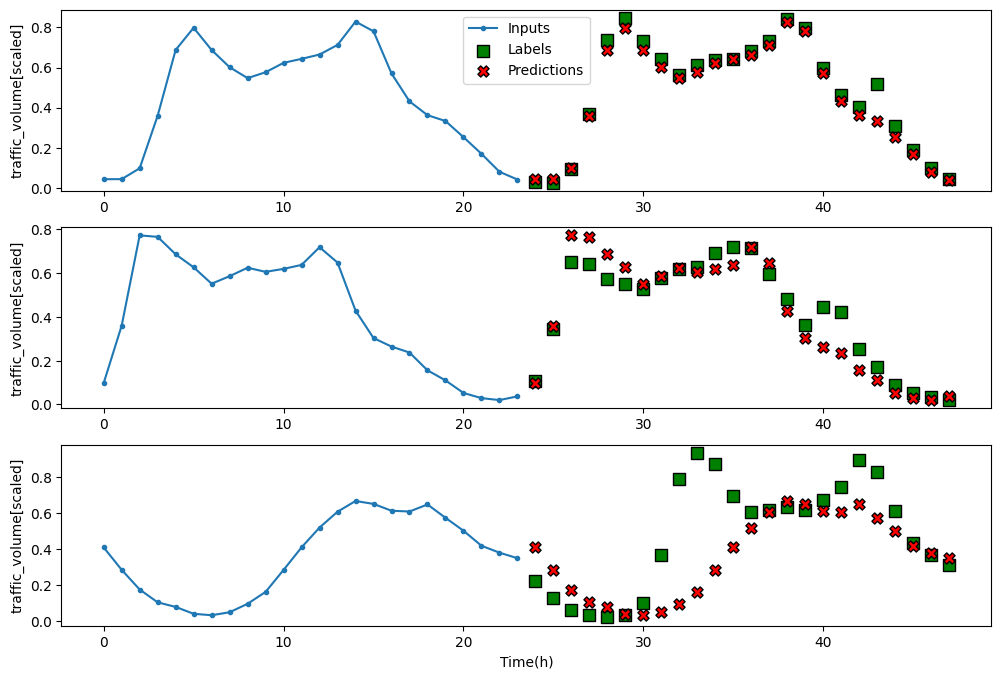

In [18]:
# 予測値の可視化
multi_window.plot(ms_baseline_repeat)

### 13.2.3 多出力のベースラインモデル

In [8]:
# シングルステップモデル用のデータウィンドウの作成（次の時間ステップを予測するモデル）
mo_single_step_window = DataWindow(
    input_width=1, 
    label_width=1, 
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temp', 'traffic_volume']
)

# プロット時に可視化できるモデルの予測値の数を増やすために、より広いウィンドウも定義
mo_wide_window = DataWindow(
    input_width=24, 
    label_width=24, 
    shift=1, 
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['temp', 'traffic_volume']
)

In [15]:
# Baselineクラスに目的変数列のインデックスを渡す
mo_baseline_last = Baseline(label_index=[0, 2])

# 評価用とテスト用のdataloaderを作成
mo_val_dataloader = mo_single_step_window.val
mo_test_dataloader = mo_single_step_window.test

# validationデータとtestデータで評価を行う
val_mse, val_mae = evaluate_model(mo_baseline_last, mo_val_dataloader)
test_mse, test_mae = evaluate_model(mo_baseline_last, mo_test_dataloader)

val_performance  = {'Baseline - Last': {'MSE': val_mse, 'MAE': val_mae}}
performance = {'Baseline - Last:': {'MSE': test_mse, 'MAE': test_mae}}

print("Validation Performance:", val_performance)
print("Test Performance:", performance)

Validation Performance: {'Baseline - Last': {'MSE': 0.006862090885723857, 'MAE': 0.0482284881005233}}
Test Performance: {'Baseline - Last:': {'MSE': 0.006413159680298783, 'MAE': 0.046987743337046015}}


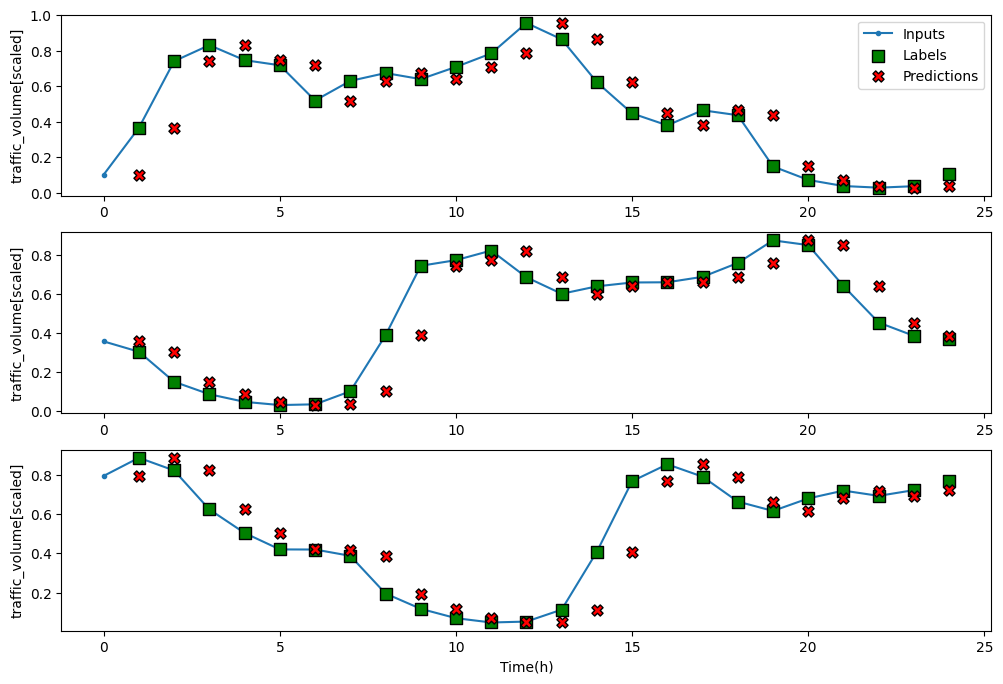

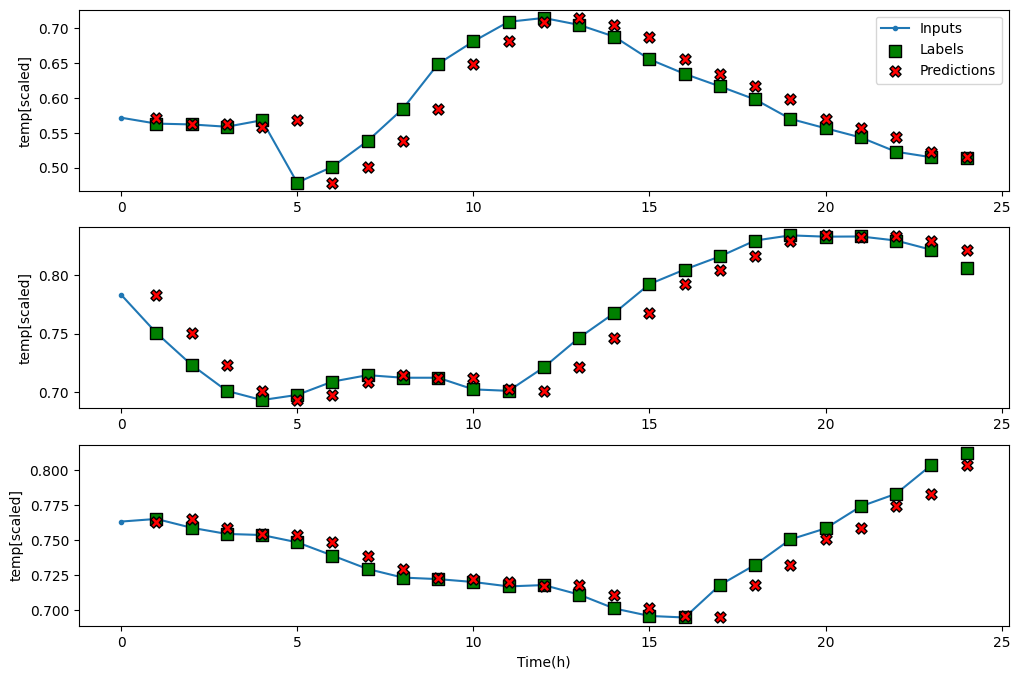

In [21]:
# 予測値の可視化
mo_wide_window.plot(mo_baseline_last)
mo_wide_window.plot(mo_baseline_last, plot_col='temp')

# 14. ディープラーニングの手ほどき

## 14.1 線形モデルを実装する

### 14.1.1 シングルステップの線形モデルを実装する

In [9]:
# モデルのコンパイルと訓練を行う関数を定義
def compile_and_fit(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                    criterion: nn.Module, optimizer: optim.Optimizer, 
                    device: torch.device, max_epochs: int = 50, patience: int = 3) -> Dict[str, List[float]]:
    """
    モデルのコンパイルとトレーニング。

    引数:
        model (nn.Module): 学習モデル。
        train_loader (DataLoader): 訓練データローダー。
        val_loader (DataLoader): 検証データローダー。
        criterion (nn.Module): 損失関数。
        optimizer (optim.Optimizer): オプティマイザ。
        device (torch.device): 実行環境。
        max_epochs (int): 最大エポック数。
        patience (int): 早期停止のエポック数。

    戻り値:
        Dict[str, List[float]]: トレーニングおよび検証損失の履歴。
    """
    trainer = ModelTrainer(model, train_loader, val_loader, criterion, optimizer, device)
    return trainer.train(max_epochs=max_epochs, patience=patience)

# モデルの評価関数を定義
def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: torch.device) -> float:
    """
    モデルの評価関数。

    引数:
        model (nn.Module): 学習済みモデル。
        data_loader (DataLoader): データローダー。
        criterion (nn.Module): 損失関数。
        device (torch.device): 実行環境。

    戻り値:
        float: 評価損失。
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [23]:
# dataloaderの作成
train_dataloader = single_step_window.train
val_dataloader = single_step_window.val
test_dataloader = single_step_window.test

# モデルとパラメータ設定
input_dim = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LinearModel(input_dim=input_dim).to(device)
criterion = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングの実行
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.5656, Val Loss: 0.2222
Epoch 2/50, Train Loss: 0.1821, Val Loss: 0.1512
Epoch 3/50, Train Loss: 0.1137, Val Loss: 0.0877
Epoch 4/50, Train Loss: 0.0733, Val Loss: 0.0674
Epoch 5/50, Train Loss: 0.0646, Val Loss: 0.0629
Epoch 6/50, Train Loss: 0.0625, Val Loss: 0.0619
Epoch 7/50, Train Loss: 0.0620, Val Loss: 0.0619
Epoch 8/50, Train Loss: 0.0619, Val Loss: 0.0620
Epoch 9/50, Train Loss: 0.0619, Val Loss: 0.0618
Epoch 10/50, Train Loss: 0.0619, Val Loss: 0.0615
Epoch 11/50, Train Loss: 0.0618, Val Loss: 0.0617
Epoch 12/50, Train Loss: 0.0618, Val Loss: 0.0615
Epoch 13/50, Train Loss: 0.0618, Val Loss: 0.0619
Early stopping triggered


In [26]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, criterion, device)
test_loss = evaluate(model, test_dataloader, criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

Validation MAE: 0.0618
Test MAE: 0.0580


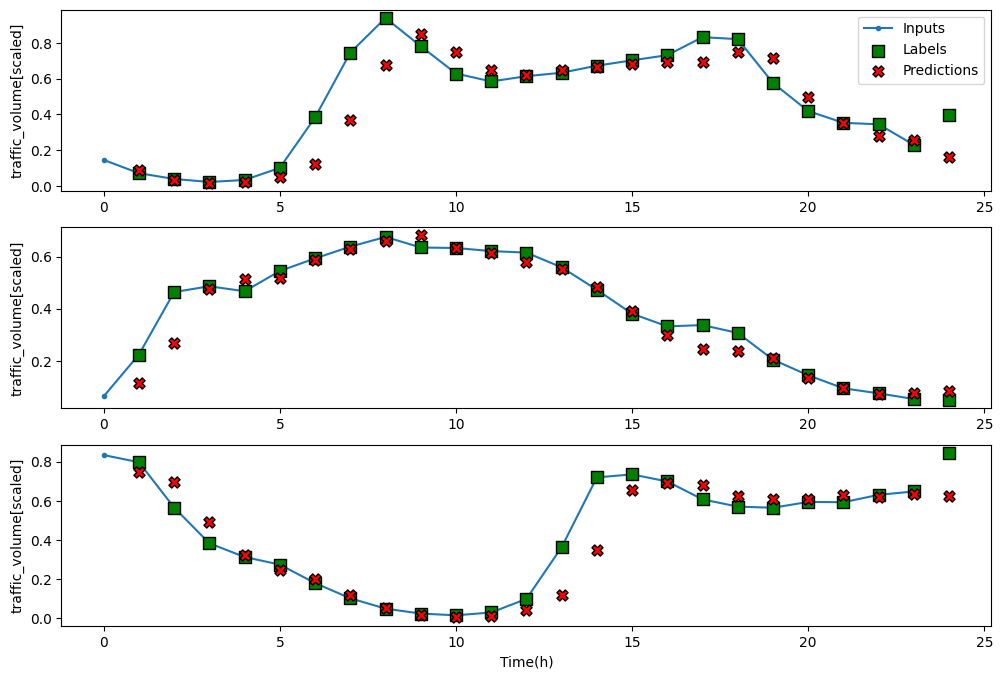

In [27]:
# 予測値の可視化
wide_window.plot(model)

### 14.1.2 マルチステップの線形モデルを実装する

In [14]:
# dataloaderの作成
train_dataloader = multi_window.train
val_dataloader = multi_window.val
test_dataloader = multi_window.test

# モデルとパラメータ設定
input_dim = 5
output_dim = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LinearModel(input_dim=input_dim, output_dim=output_dim).to(device)
criterion = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングの実行
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.2756, Val Loss: 0.1757
Epoch 2/50, Train Loss: 0.1223, Val Loss: 0.1080
Epoch 3/50, Train Loss: 0.0938, Val Loss: 0.0956
Epoch 4/50, Train Loss: 0.0877, Val Loss: 0.0906
Epoch 5/50, Train Loss: 0.0846, Val Loss: 0.0874
Epoch 6/50, Train Loss: 0.0820, Val Loss: 0.0846
Epoch 7/50, Train Loss: 0.0799, Val Loss: 0.0825
Epoch 8/50, Train Loss: 0.0782, Val Loss: 0.0810
Epoch 9/50, Train Loss: 0.0772, Val Loss: 0.0802
Epoch 10/50, Train Loss: 0.0766, Val Loss: 0.0798
Epoch 11/50, Train Loss: 0.0764, Val Loss: 0.0796
Epoch 12/50, Train Loss: 0.0763, Val Loss: 0.0798
Epoch 13/50, Train Loss: 0.0763, Val Loss: 0.0795
Epoch 14/50, Train Loss: 0.0762, Val Loss: 0.0796
Epoch 15/50, Train Loss: 0.0762, Val Loss: 0.0800
Epoch 16/50, Train Loss: 0.0763, Val Loss: 0.0798
Early stopping triggered


In [15]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, criterion, device)
test_loss = evaluate(model, test_dataloader, criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

Validation MAE: 0.0797
Test MAE: 0.0663


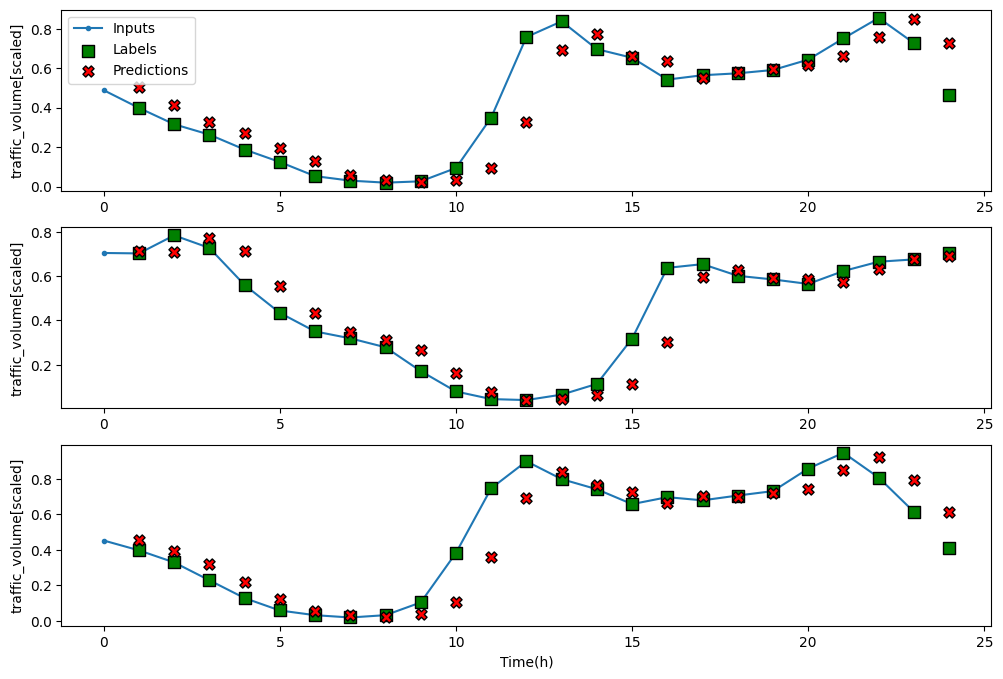

In [16]:
# 予測値の可視化
wide_window.plot(model)

### 14.1.3 多出力の線形モデルを実装する

In [17]:
# dataloaderの作成
train_dataloader = mo_single_step_window.train
val_dataloader = mo_single_step_window.val
test_dataloader = mo_single_step_window.test

# モデルとパラメータ設定
input_dim = 5
output_dim = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LinearModel(input_dim=input_dim, output_dim=output_dim).to(device)
criterion = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングの実行
history = compile_and_fit(model, 
                          train_dataloader, 
                          val_dataloader, 
                          criterion, 
                          optimizer,
                          device,
                          max_epochs=50,
                          patience=3
)

Epoch 1/50, Train Loss: 0.2906, Val Loss: 0.2024
Epoch 2/50, Train Loss: 0.1459, Val Loss: 0.1105
Epoch 3/50, Train Loss: 0.0842, Val Loss: 0.0702
Epoch 4/50, Train Loss: 0.0562, Val Loss: 0.0461
Epoch 5/50, Train Loss: 0.0396, Val Loss: 0.0357
Epoch 6/50, Train Loss: 0.0365, Val Loss: 0.0362
Epoch 7/50, Train Loss: 0.0364, Val Loss: 0.0358
Epoch 8/50, Train Loss: 0.0364, Val Loss: 0.0358
Early stopping triggered


In [18]:
# valデータとtestデータの評価
val_loss = evaluate(model, val_dataloader, criterion, device)
test_loss = evaluate(model, test_dataloader, criterion, device)

print(f'Validation MAE: {val_loss:.4f}')
print(f'Test MAE: {test_loss:.4f}')

Validation MAE: 0.0359
Test MAE: 0.0337


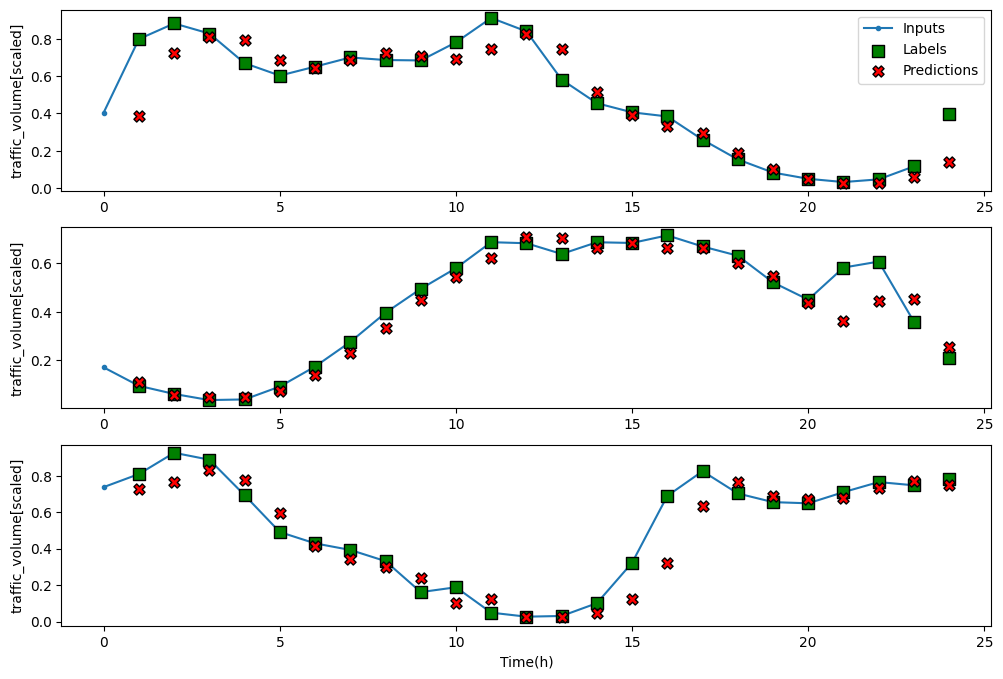

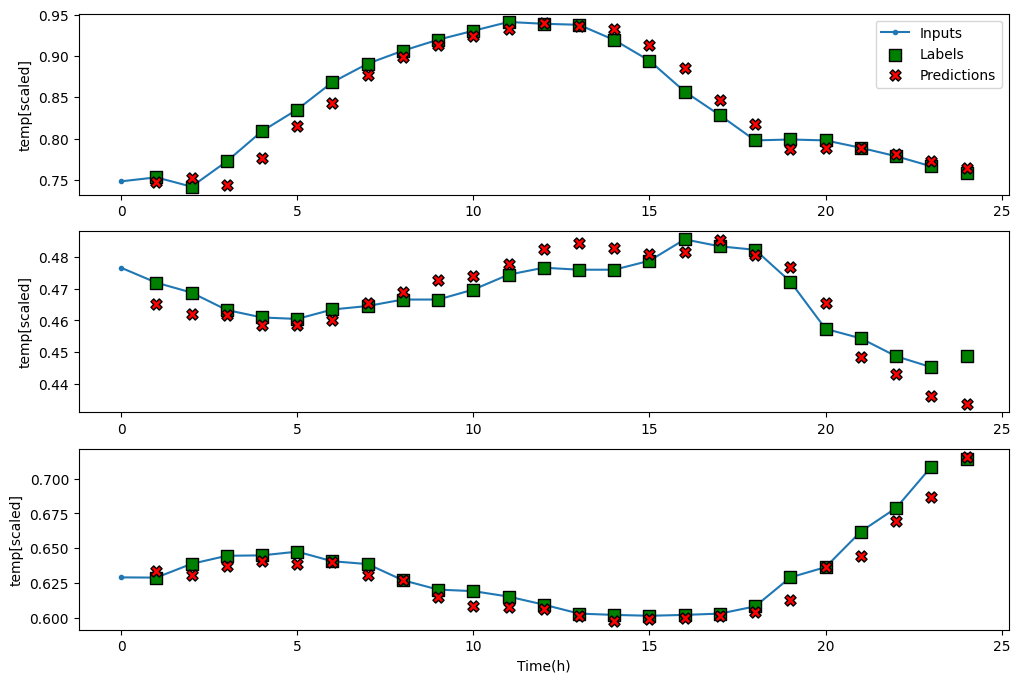

In [20]:
# 予測値の可視化
mo_wide_window.plot(model)
mo_wide_window.plot(model, plot_col='temp')

## 14.2 ディープニューラルネットワーク（DNN）を実装する